# Self-supervised Vision Transformer for Land Cover Classification and Segmentation: Swin Transformer + Sentinel-1/2 Demo

Linus Scheibenreif, Joëlle Hanna, [University of St.Gallen,  School of Computer Science, AIML Lab](https://ics.unisg.ch/chair-aiml-borth/)


This notebook contains sample code for fine-tuning of the pretrained Swin Transformer backbones from this work. The two backbones, utilizing Sentinel-1 SAR data and Sentinel-2 multi-band imaging, can be used separately or in a combined way. In this example, we will fine-tune the Swin Transformer backbones to an image classification task, utilizing both Sentinel-1 and Sentinel-2 data from the DFC2020 dataset. However, we would like to point out that the backbones are task agnostic and can be trained on any properly formatted Sentinel-1/2 dataset.

For further information, or to cite our work if you utilize this code, please refer to:

[Linus Scheibenreif, Joëlle Hanna, Michael Mommert, Damian Borth, *Self-Supervised Vision Transformers for Land-Cover Segmentation and Classification*, Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) Workshops, 2022, pp. 1422-1431](https://openaccess.thecvf.com/content/CVPR2022W/EarthVision/html/Scheibenreif_Self-Supervised_Vision_Transformers_for_Land-Cover_Segmentation_and_Classification_CVPRW_2022_paper.html)

## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

<a id='installation'></a>
## 1. Installation

First, start by cloning this repository:
```bash
git clone https://github.com/HSG-AIML/SSLTransformerRS.git
```

#### Dependencies

This project uses Python 3.8, and the dependencies listed in `requirements.txt` can be installed with `pip` or `conda`, in a virtual environment. For example, using `pip`:
```bash
pip install -r requirements.txt
```

In [1]:
# Import needed packages
import argparse
import json
import os
import random
import numpy as np
import torch
import wandb
import torch.nn.functional as F
from distutils.util import strtobool
from tqdm import tqdm
from torchvision.models import resnet18, resnet50

<a id='dataset'></a>
## 2. Dataset


#### Download

Any Sentinel-1 data, Sentinel-2 data or a fusion of both could be used. In this demo, we will use the DFC2020 dataset to train downstream tasks. You can download it using this [link](https://ieee-dataport.org/competitions/2020-ieee-grss-data-fusion-contest). We are using multimodal input here (fusion of Sentinel-1 and Sentinel-2) but keep in mind that a uni-modal input (Sentinel-1 only or Sentinel-2 only) can be used as well (you can see an example in the notebook `demo_resnet_backbone.ipynb`)



#### Configure 

For example, in the `data_config` dictionary (cell below), you can specify paths to the data directory with `train_dir` and `val_dir` or the image input size with `image_px_size`.

In [2]:
# Data configurations:
data_config = {
    'train_dir': '/data/grss-dfc-20', # path to the training directory,  
    'val_dir': '/data/grss-dfc-20', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [3]:
# Ensure deterministic behavior
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [4]:
from dfc_dataset import DFCDataset

# Create Training Dataset
train_dataset = DFCDataset(
    data_config['train_dir'],
    mode=data_config['train_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['train_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_train'],
    seed=data_config['seed'],
)

# Create Validation Dataset
val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed'],
)

We can see how many examples are in each split by checking their length:

In [5]:
len(train_dataset), len(val_dataset)

(986, 5128)

We can also display some examples:

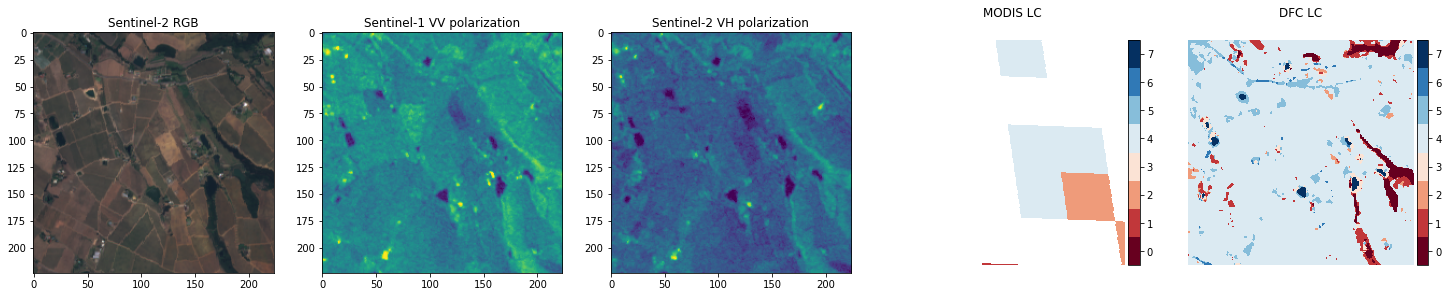

In [6]:
train_dataset.visualize_observation(67)

The plots show, from left to right: Sentinel-2 true color image, Sentinel-1 maps for the two different polarizations, a coarse MODIS LULC map and the high-resolution DFC2020 LULC map.

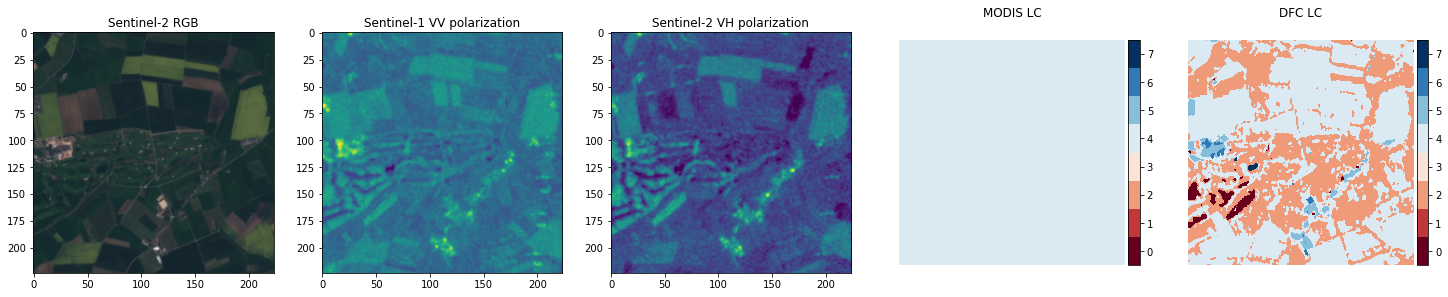

In [7]:
val_dataset.visualize_observation(67)

We define a correspondance of label and names:

In [8]:
DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

Our data is now ready to be used by the model. In the next section we load and configure the model. 

<a id='quickstart'></a>
## 3. Quick Start

#### Configure 

You can specify in the some hyperparameters in `train_config` (cell below), such as the `learning_rate`, the `batch_size`, number of `epochs`, or if you wish to fine-tune the model or not (with the `finetuning` argument), etc.

In [9]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 5, 
    'target': 'dfc_label'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1e7QhC2-zoBFgb65yN1ADWBZLMShHOweY/view), save it in the `checkpoints/` directory then run the following cell.

Make sure to properly modify the path to the downloaded checkpoint in the path below.

In the case where you are using a uni-modal dataset (Sentinel-2 only or Sentinel-1 only), you can load the corresponding weight stream `s1_weights` or `s2_weights`, and comment the other one.

In [10]:
# path to the checkpoint
checkpoint = torch.load(
    "checkpoints/d-swimdistinctive-armadillo-24-epoch150.pth"
) 
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

#### Prepare model and load checkpoint

We prepare the model by specifying the `input_channels`: only sentinel1, only sentinel2 or both. We also specify if we need both backbones `s1_backbone` and `s2_backbone` depending on our application. In the case where only one stream is needed, just comment the lines `s1_backbone` or `s2_backbone`.

In [11]:
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from utils import save_checkpoint_single_model, dotdictify
from Transformer_SSL.models import build_model


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

# Input channel size
input_channels = train_config['s1_input_channels'] + train_config['s2_input_channels']

# If you are using a uni-modal dataset, you can un-comment one of these lines, and comment the one above:
# input_channels = train_config['s1_input_channels']
# input_channels = train_config['s2_input_channels']

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

We create the downstream model head that will be trained. In this demo, we will train a classifier. You can find a segmentation head in the repository (/TransformerSSL/models/swin_transformer/DoubleSwinTransformerSegmentation). Our classifier takes as input the pre-trained backbone (in the form of two streams `encoder1` and `encoder2`), the `out_dim` (number of classes), and `freeze_layers` flag, specifying whether you wish to freeze the backbone weights or not.

In [12]:
class DoubleSwinTransformerClassifier(torch.nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=True):
        super(DoubleSwinTransformerClassifier, self).__init__()
        
        # If you're only using one of the two backbones, just comment the one you don't need
        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.device = device

        # add final linear layer
        self.fc = torch.nn.Linear(
            self.backbone2.num_features + self.backbone1.num_features,
            out_dim,
            bias=True,
        )

        # freeze all layers but the last fc
        if freeze_layers:
            for name, param in self.named_parameters():
                if name not in ["fc.weight", "fc.bias"]:
                    param.requires_grad = False

    def forward(self, x):
        x1, _, _ = self.backbone1.forward_features(x["s1"].to(self.device))
        x2, _, _ = self.backbone2.forward_features(x["s2"].to(self.device))

        z = torch.cat([x1, x2], dim=1)
        z = self.fc(z)
        
        # If you're only using one of the two backbones, you may comment the lines above and use the following:
        # x1, _, _ = self.backbone1.forward_features(x["s1"].to(self.device))
        # z = self.fc(x1)

        return z

In [13]:
model = DoubleSwinTransformerClassifier(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device
    )

model = model.to(device)

Define and initialise the loss for training. Here we are training for single-class classification and using a `torch.nn.CrossEntropyLoss` loss. 

In [14]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Define the trainable parameters (needed for the optimizer):

In [15]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Finetuning


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want. 

In [16]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader 

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

Everything is set and we are now ready to train the classifier head:

In [18]:
from metrics import ClasswiseAccuracy
from validation_utils import validate_all

step = 0

# Training loop

for epoch in range(train_config['epochs']):
    # Model Training
    model.train()
    step += 1

    pbar = tqdm(train_loader)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = ClasswiseAccuracy(data_config['num_classes'])

    for idx, sample in enumerate(pbar):

        if "x" in sample.keys():
            if torch.isnan(sample["x"]).any():
                # some s1 scenes are known to have NaNs...
                continue
        else:
            if torch.isnan(sample["s1"]).any() or torch.isnan(sample["s2"]).any():
                # some s1 scenes are known to have NaNs...
                continue
        
        # load input
        s1 = sample["s1"].to(device)
        s2 = sample["s2"].to(device)
        img = {"s1": s1, "s2": s2}
        
        # if you are using a unimodal dataset (s1 for example), you may comment the lines above and use the following:
        # s1 = sample["s1"].to(device)
        # img = {"s1": s1}
        
        # load target
        y = sample[train_config['target']].long().to(device)
        
        # model output
        y_hat = model(img)
        
        # loss computation
        loss = criterion(y_hat, y)
        
        # backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # get prediction 
        _, pred = torch.max(y_hat, dim=1)

        epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
        metrics.add_batch(y, pred)

        pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

    mean_loss = epoch_losses.mean()

    train_stats = {
            "train_loss": mean_loss.item(),
            "train_average_accuracy": metrics.get_average_accuracy(),
            "train_overall_accuracy": metrics.get_overall_accuracy(),
            **{
                "train_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
        }
    print(train_stats)

    if epoch % 2 == 0:  

        # Model Validation
        model.eval()
        pbar = tqdm(val_loader)

        # track performance
        epoch_losses = torch.Tensor()
        metrics = ClasswiseAccuracy(data_config['num_classes'])

        with torch.no_grad():
            for idx, sample in enumerate(pbar):
                if "x" in sample.keys():
                    if torch.isnan(sample["x"]).any():
                        # some s1 scenes are known to have NaNs...
                        continue
                else:
                    if torch.isnan(sample["s1"]).any() or torch.isnan(sample["s2"]).any():
                        # some s1 scenes are known to have NaNs...
                        continue
                # load input
                s1 = sample["s1"].to(device)
                s2 = sample["s2"].to(device)
                img = {"s1": s1, "s2": s2}

                # if you are using a unimodal dataset (s1 for example), you may comment the lines above and use the following:
                # s1 = sample["s1"].to(device)
                # img = {"s1": s1}

                # load target
                y = sample[train_config['target']].long().to(device)

                # model output
                y_hat = model(img)

                # loss computation
                loss = criterion(y_hat, y)

                # get prediction 
                _, pred = torch.max(y_hat, dim=1)

                epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
                metrics.add_batch(y, pred)


                pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

            mean_loss = epoch_losses.mean()

            val_stats = {
                "validation_loss": mean_loss.item(),
                "validation_average_accuracy": metrics.get_average_accuracy(),
                "validation_overall_accuracy": metrics.get_overall_accuracy(),
                **{
                    "validation_accuracy_" + k: v
                    for k, v in metrics.get_classwise_accuracy().items()
                },
            }

            print(f"Epoch:{epoch}", val_stats)
            
            # Save model checkpoint every 2 epochs 
            if epoch % 2 == 0:
                if epoch == 0:
                    continue

                save_weights_path = (
                    "checkpoints/" + "-".join(["classifier", "epoch", str(epoch)]) + ".pth"
                )
                torch.save(model.state_dict(), save_weights_path)


Epoch:0, Training Loss:0.8249: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:20<00:00,  2.99it/s]


{'train_loss': 0.8248856067657471, 'train_average_accuracy': 0.5193046429101402, 'train_overall_accuracy': 0.7251521298174443, 'train_accuracy_class_7': 0.9541547277936963, 'train_accuracy_class_5': 0.7457627118644068, 'train_accuracy_class_4': 0.7483870967741936, 'train_accuracy_class_3': 0.7377049180327869, 'train_accuracy_class_2': 0.5242718446601942, 'train_accuracy_class_0': 0.4155844155844156, 'train_accuracy_class_6': 0.0, 'train_accuracy_class_1': 0.02857142857142857}


Validation Loss:1.357: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [01:22<00:00,  3.89it/s]


Epoch:0 {'validation_loss': 1.3800075054168701, 'validation_average_accuracy': 0.4390751380788619, 'validation_overall_accuracy': 0.5040951638065523, 'validation_accuracy_class_7': 0.9882943143812709, 'validation_accuracy_class_0': 0.08410596026490066, 'validation_accuracy_class_4': 0.6132231404958678, 'validation_accuracy_class_5': 0.8651685393258427, 'validation_accuracy_class_1': 0.08865248226950355, 'validation_accuracy_class_3': 0.7272727272727273, 'validation_accuracy_class_2': 0.056140350877192984, 'validation_accuracy_class_6': 0.08974358974358974}


Epoch:1, Training Loss:0.4742: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:17<00:00,  3.52it/s]


{'train_loss': 0.47422006726264954, 'train_average_accuracy': 0.6775809522509453, 'train_overall_accuracy': 0.8296146044624746, 'train_accuracy_class_0': 0.6533333333333333, 'train_accuracy_class_7': 0.9829059829059829, 'train_accuracy_class_4': 0.8387096774193549, 'train_accuracy_class_6': 0.13043478260869565, 'train_accuracy_class_3': 0.8232044198895028, 'train_accuracy_class_2': 0.7156862745098039, 'train_accuracy_class_1': 0.40540540540540543, 'train_accuracy_class_5': 0.8709677419354839}


Epoch:2, Training Loss:0.4235: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  3.89it/s]


{'train_loss': 0.4235379695892334, 'train_average_accuracy': 0.735563391292475, 'train_overall_accuracy': 0.8549695740365112, 'train_accuracy_class_3': 0.8432432432432433, 'train_accuracy_class_1': 0.5555555555555556, 'train_accuracy_class_7': 0.9914285714285714, 'train_accuracy_class_4': 0.875, 'train_accuracy_class_2': 0.6470588235294118, 'train_accuracy_class_6': 0.30434782608695654, 'train_accuracy_class_5': 0.9016393442622951, 'train_accuracy_class_0': 0.7662337662337663}


Validation Loss:1.278: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [01:21<00:00,  3.92it/s]


Epoch:2 {'validation_loss': 1.2938549518585205, 'validation_average_accuracy': 0.4525679505341268, 'validation_overall_accuracy': 0.5859984399375975, 'validation_accuracy_class_7': 0.994979079497908, 'validation_accuracy_class_0': 0.38681757656458055, 'validation_accuracy_class_4': 0.5824357912178956, 'validation_accuracy_class_5': 0.8715083798882681, 'validation_accuracy_class_6': 0.10126582278481013, 'validation_accuracy_class_1': 0.09747292418772563, 'validation_accuracy_class_2': 0.030508474576271188, 'validation_accuracy_class_3': 0.5555555555555556}


Epoch:3, Training Loss:0.3957: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:19<00:00,  3.13it/s]


{'train_loss': 0.3956748843193054, 'train_average_accuracy': 0.755909171731294, 'train_overall_accuracy': 0.8580121703853956, 'train_accuracy_class_7': 0.9829545454545454, 'train_accuracy_class_1': 0.5428571428571428, 'train_accuracy_class_0': 0.8571428571428571, 'train_accuracy_class_2': 0.6666666666666666, 'train_accuracy_class_4': 0.8717948717948718, 'train_accuracy_class_3': 0.8222222222222222, 'train_accuracy_class_6': 0.43478260869565216, 'train_accuracy_class_5': 0.8688524590163934}


Epoch:4, Training Loss:0.3651: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.02it/s]


{'train_loss': 0.36512818932533264, 'train_average_accuracy': 0.793532224069667, 'train_overall_accuracy': 0.8671399594320487, 'train_accuracy_class_0': 0.8076923076923077, 'train_accuracy_class_7': 0.9971509971509972, 'train_accuracy_class_3': 0.8087431693989071, 'train_accuracy_class_2': 0.7549019607843137, 'train_accuracy_class_5': 0.9152542372881356, 'train_accuracy_class_6': 0.6818181818181818, 'train_accuracy_class_4': 0.8300653594771242, 'train_accuracy_class_1': 0.5526315789473685}


Validation Loss:1.506: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [01:27<00:00,  3.67it/s]


Epoch:4 {'validation_loss': 1.5424126386642456, 'validation_average_accuracy': 0.4805030187043937, 'validation_overall_accuracy': 0.5432917316692668, 'validation_accuracy_class_7': 0.9966499162479062, 'validation_accuracy_class_0': 0.06875834445927904, 'validation_accuracy_class_4': 0.7227235438884332, 'validation_accuracy_class_5': 0.7846441947565543, 'validation_accuracy_class_1': 0.5234657039711191, 'validation_accuracy_class_2': 0.013888888888888888, 'validation_accuracy_class_6': 0.38095238095238093, 'validation_accuracy_class_3': 0.35294117647058826}


You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

Predicted class: Croplands
Ground-truth class:  Croplands


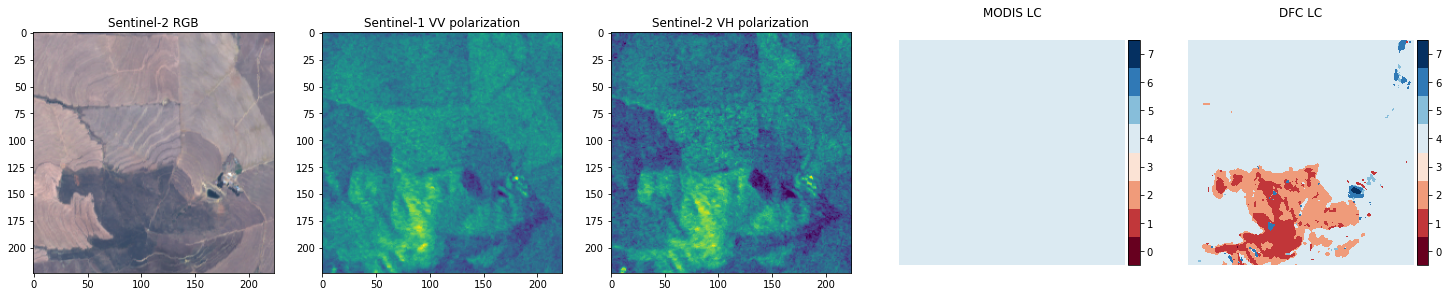

In [19]:
# create a new model's instance
model = DoubleSwinTransformerClassifier(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)

model = model.to(device)

# load checkpoints weights
model.load_state_dict(torch.load("checkpoints/classifier-epoch-4.pth"))

# prepare input and feed it to model for evaluation
img = {"s1": torch.unsqueeze(val_dataset[2]['s1'], 0), "s2": torch.unsqueeze(val_dataset[2]['s2'], 0)} # adding an extra dimension for batch information
model.eval()
output = model(img)

# display predicted class:
print(f'Predicted class: {DFC_map_clean[torch.argmax(output).item()]}')

# display ground-truth label:
print('Ground-truth class: ', DFC_map_clean[val_dataset[2][train_config['target']]])

# display image
val_dataset.visualize_observation(2)